In [50]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt

In [51]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
data = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, data)

In [52]:
print(load_path)

/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr/testdata_two_days_2019_01_01-02.zarr


In [53]:
data = xr.open_dataset(folder_path) # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason


In [54]:
print(data.dims)

FrozenMappingWarningOnValuesAccess({'step': 1, 'time': 576, 'y': 1200, 'x': 1100})


In [55]:
py, px = 128, 128 # how many pixels in y and x direction
pt = 4 # how many time steps to include in a sample (i.e. context and target)
threshold = 1e-4 # threshold for filter condition
# define slices for the center pixels of the blocks to apply the filter to
length_width_center_even = 32

In [56]:

center_x = slice(px // 2 - length_width_center_even // 2, px // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
center_y = slice(py // 2 - length_width_center_even // 2, py // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
coarse = data.coarsen(
    y = py,
    x = px,
    time = pt, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small
# construct a new data set, where the blocks are folded into a new dimension
folded = coarse.construct(
    time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
# get the value of the center pixels of each block and take their mean
center = folded.isel(
    y_inner = center_y,
    x_inner = center_x).mean(("y_inner", "x_inner", "time_inner"))

# define a threshold for the center pixels, i.e. the filter condition
valid_center = center > threshold


In [57]:
valid_center

<xarray.Dataset> Size: 10kB
Dimensions:    (step: 1, time_outer: 144, y_outer: 9, x_outer: 8)
Coordinates:
  * step       (step) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: time_outer, y_outer, x_outer
Data variables:
    RV_recalc  (step, time_outer, y_outer, x_outer) bool 10kB False ... False

In [58]:
folded

<xarray.Dataset> Size: 3GB
Dimensions:                 (step: 1, time_outer: 144, time_inner: 4,
                             y_outer: 9, y_inner: 128, x_outer: 8, x_inner: 128)
Coordinates:
    latitude                (y_outer, y_inner, x_outer, x_inner) float64 9MB ...
    longitude               (y_outer, y_inner, x_outer, x_inner) float64 9MB ...
    missing_data_RV_recalc  (step, time_outer, time_inner) float32 2kB 0.0 .....
  * step                    (step) timedelta64[ns] 8B 00:00:00
    time                    (time_outer, time_inner) datetime64[ns] 5kB 2019-...
    x                       (x_outer, x_inner) float64 8kB -543.5 ... 479.5
    y                       (y_outer, y_inner) float64 9kB -3.61e+03 ... -4.7...
Dimensions without coordinates: time_outer, time_inner, y_outer, y_inner,
                                x_outer, x_inner
Data variables:
    RV_recalc               (step, time_outer, time_inner, y_outer, y_inner, x_outer, x_inner) float32 3GB ...
Attributes:
    crs:        +proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +...
    nodata:     nan
    notes:      The grid point RV_recalc[0,0] corresponds to the top-left cor...
    transform:  [1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

In [59]:
valid_center.RV_recalc.values

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False,  True, ..., False,  True, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False,  True, ...,  True,  True, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False,  True, ...,  True, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

In [60]:
# get the outer coordinates for all valid blocks (valid_time, valid_x, valid_y)
valid_coords = np.array(np.nonzero(valid_center.RV_recalc.values))#.T
# For data loading purposes, we can use the valid_coords to get the corresponding blocks
# For example, to get a random block from the valid blocks, we can do the following:
# get a random element from the valid coordinates
sample_coord = valid_coords[np.random.randint(0, valid_coords.shape[0])]
# get the block at the sample coordinate
sample_block = folded.isel(time_outer = sample_coord[0],
                           y_outer = sample_coord[2],
                           x_outer = sample_coord[1])

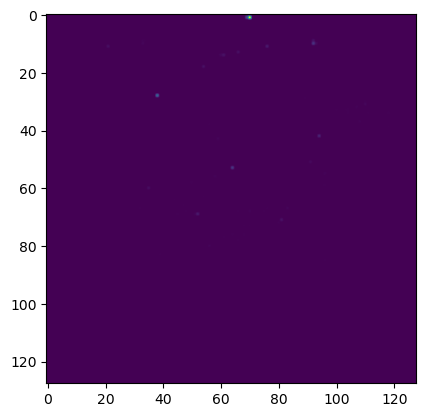

In [61]:
sample_block_vals = sample_block.RV_recalc.values[0,0,:,:]
plt.figure()
plt.imshow(sample_block_vals, cmap='viridis')
# group by day xarray --> group by day to split in training and validation

In [49]:
valid_coords

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 143, 143, 143],
       [  1,   2,   2, ...,   7,   7,   8],
       [  5,   2,   4, ...,   5,   6,   3]])